In [46]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# Load your data
on_base_lf = pl.scan_parquet("../data/throw_home_runner_on_third_wide_sprint_arm.parquet")

# If hieght of ending location is less then 0.1 ft then it bounced
on_base_lf = on_base_lf.with_columns(
    pl.when(pl.col("end_pos_z") < 0.1)
    .then(True)
    .otherwise(False)
    .alias("ball_bounce")
)

# Distance from landing to home.
on_base_lf = on_base_lf.with_columns((
  (pl.col("landing_pos_x").pow(2) + pl.col("landing_pos_y").pow(2)).sqrt()
  ).alias("landing_to_home")
)

# Filter for throws that were within a 30 ft radius
on_base_lf = on_base_lf.filter(
    pl.col("landing_to_home") < 30
)

# Select relevant columns and drop nulls
on_base_pl = on_base_lf.select([
    "distance_traveled_fielder",
    "distance_catch_to_home",
    "distance_to_home_diff",
    "seconds_since_hit_085_mlb_person_id_R3",
    "max_arm_strength_fielder_mlb_person_id",
    "ball_bounce",
    "landing_to_home",
    "is_successful",
]).drop_nulls().collect()

on_base_pl.shape

(850, 8)

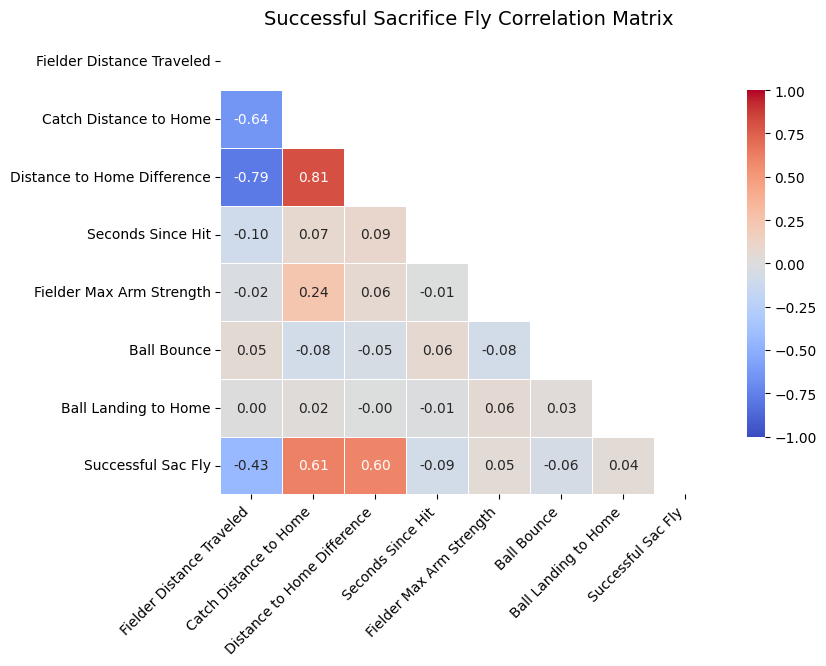

In [50]:
# Calculate the correlation matrix and convert to Pandas
on_base_corr = on_base_pl.to_pandas().corr()

# Create a mask to hide the upper triangle
mask = np.zeros_like(on_base_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Improve column names for readability (optional but recommended)
readable_labels = {
    "distance_traveled_fielder": "Fielder Distance Traveled",
    "distance_traveled_all_fielders": "All Fielders Distance Traveled",
    "distance_catch_to_home": "Catch Distance to Home",
    "distance_to_home_diff": "Distance to Home Difference",
    "seconds_since_hit_085_mlb_person_id_R3": "Seconds Since Hit",
    "max_arm_strength_fielder_mlb_person_id": "Fielder Max Arm Strength",
    "ball_bounce": "Ball Bounce",
    "landing_to_home": "Ball Landing to Home",
    "is_successful": "Successful Sac Fly"
}
on_base_corr.rename(index=readable_labels, columns=readable_labels, inplace=True)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(on_base_corr,
            mask=mask,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",
            linewidths=.5,
            cbar_kws={"shrink": .75})
plt.title('Successful Sacrifice Fly Correlation Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# plt.tight_layout()
plt.show()